### Sunrise model
based on a labeled weather dataset, predict whether the next sunrise will be beautiful
- takes in weather vector for entire day for 365 days in COS AND label of good or bad

In [98]:
import torch
import os 
import numpy as np
import matplotlib.pyplot as plt

# dependencies: python 3.9, numpy 1.19.5

- load in weather data using only valid columns, leaving out the last column (wind chill label)
- create a tensor from all data

In [143]:
input_path = "prepped_data_1.csv"
test_path = "test_data_1.csv"
weather_data = np.genfromtxt(input_path,delimiter = ",", skip_header = 1, filling_values=0.0)
weather_tensor = torch.tensor(weather_data).float()

SETTING = "sunrise" 

read in as a tensor dataset

In [144]:
# get labels from the sunrise, sunset columns

sunrise_labels = weather_tensor[:, -2]
sunset_labels = weather_tensor[:, -1]
data = weather_tensor[:,:-2] # all weather data except sunrise and sunset labels


In [145]:
# TEST = the last 365 days worth
# TEST = 8760
# sunrise_labels = weather_tensor[-TEST:, -2]
# sunset_labels = weather_tensor[-TEST:, -1]
# data = weather_tensor[-TEST:,:-2] # all weather data except sunrise and sunset labels

# normalization

In [146]:
# calculate mean and std and do the normalization by hand 
m = torch.mean(data, dim = 0)
s = torch.std(data, dim = 0)

norm_data = (data - m)/s


m = m.detach().numpy().tolist()
s = s.detach().numpy().tolist()

# print(m)

import json

mean = json.dumps(m)
std = json.dumps(s)


with open('mean.json', 'w') as f:
    f.write(mean)
with open('std.json', 'w') as f:
    f.write(std)


In [102]:
weather_dataset = torch.utils.data.TensorDataset(norm_data, sunrise_labels)
# number of columns (minus the labels columns)
xdims = weather_tensor.shape[1] - 2
# number of rows 
ydims = weather_tensor.shape[0]


# test_sunrise_labels = weather_tensor[-TEST:, -2]
# test_sunset_labels = weather_tensor[-TEST:, -1]
# test_data = weather_tensor[-TEST:,:-2] 

DataLoader 
puts data on the right device, shuffles, can use parallel programming, define batch size etc
- sees everything in an epoch
- next epoch, sees them in a different order
- suffles with 32 irows in a batch


In [103]:
loader = torch.utils.data.DataLoader(weather_dataset, shuffle=True, batch_size=32)


In [104]:
net = torch.nn.Sequential(
    torch.nn.Linear(xdims, 32), # takes in x dims columns, then funnels to a hidden layer of 32
    torch.nn.ELU(), 
    # ELU is an activation layer, like a sigmoidal function!
    torch.nn.Linear(32, 32),
    torch.nn.ELU(),
    torch.nn.Linear(32, 16),
    torch.nn.ELU(),
    torch.nn.Linear(16, 1)
)


In [115]:
# Mean squared error loss function
# criterion = torch.nn.MSELoss()

## changing this to binary cross entropy with logits 
# w logits is more numerically stable 
criterion = torch.nn.BCEWithLogitsLoss() 

In [116]:
# optimizer called Adam, using a learning rate of 1e-4
opt = torch.optim.Adam(net.parameters(), 1e-4 )


Training loop

In [117]:
for ep in range(1000):
    # every epoch sees every row exactly one time, but inputs are shuffled every epoch
    total_loss = 0.0

    # batch by batch
    for batch in loader:

        opt.zero_grad()

        batchX = batch[0]
        batchY = batch[1].unsqueeze(-1) # take this from size [21] --> size [21, 1]

        pred = net(batchX)
        loss = criterion(pred, batchY)

        loss.backward()
        opt.step()
        total_loss += loss
        
    if ep%30 == 0: 
        print("--- epoch " + str(ep))
        print(total_loss)
            


--- epoch 0
tensor(1202.2461, grad_fn=<AddBackward0>)
--- epoch 30
tensor(1102.2493, grad_fn=<AddBackward0>)
--- epoch 60
tensor(1093.4526, grad_fn=<AddBackward0>)
--- epoch 90
tensor(1087.2734, grad_fn=<AddBackward0>)
--- epoch 120
tensor(1081.5724, grad_fn=<AddBackward0>)
--- epoch 150
tensor(1076.0769, grad_fn=<AddBackward0>)
--- epoch 180
tensor(1070.4724, grad_fn=<AddBackward0>)
--- epoch 210
tensor(1064.5874, grad_fn=<AddBackward0>)
--- epoch 240
tensor(1058.8632, grad_fn=<AddBackward0>)
--- epoch 270
tensor(1053.1102, grad_fn=<AddBackward0>)
--- epoch 300
tensor(1047.9794, grad_fn=<AddBackward0>)
--- epoch 330
tensor(1042.7988, grad_fn=<AddBackward0>)
--- epoch 360
tensor(1038.8032, grad_fn=<AddBackward0>)
--- epoch 390
tensor(1033.8427, grad_fn=<AddBackward0>)
--- epoch 420
tensor(1029.2599, grad_fn=<AddBackward0>)
--- epoch 450
tensor(1025.2666, grad_fn=<AddBackward0>)
--- epoch 480
tensor(1020.4306, grad_fn=<AddBackward0>)
--- epoch 510
tensor(1016.4425, grad_fn=<AddBackward0

### Test data


In [157]:
test_data = np.genfromtxt(input_path,delimiter = ",", skip_header = 1, filling_values=0.0)
test_tensor = torch.tensor(test_data).float()
test_data = test_tensor[:,:-2]

# sunrise
test_labels = test_tensor[:,-2] 

# sunset
#test_labels = test_tensor[:,-1] 


# Confusion Matrix


[tensor([0.6912], grad_fn=<SigmoidBackward0>), tensor([0.6755], grad_fn=<SigmoidBackward0>), tensor([0.7496], grad_fn=<SigmoidBackward0>), tensor([0.6784], grad_fn=<SigmoidBackward0>), tensor([0.6614], grad_fn=<SigmoidBackward0>), tensor([0.7237], grad_fn=<SigmoidBackward0>), tensor([0.6582], grad_fn=<SigmoidBackward0>), tensor([0.3122], grad_fn=<SigmoidBackward0>), tensor([0.2026], grad_fn=<SigmoidBackward0>), tensor([0.2141], grad_fn=<SigmoidBackward0>), tensor([0.4772], grad_fn=<SigmoidBackward0>), tensor([0.1661], grad_fn=<SigmoidBackward0>), tensor([0.1395], grad_fn=<SigmoidBackward0>), tensor([0.2065], grad_fn=<SigmoidBackward0>), tensor([0.2212], grad_fn=<SigmoidBackward0>), tensor([0.4660], grad_fn=<SigmoidBackward0>), tensor([0.4775], grad_fn=<SigmoidBackward0>), tensor([0.4479], grad_fn=<SigmoidBackward0>), tensor([0.3034], grad_fn=<SigmoidBackward0>), tensor([0.1737], grad_fn=<SigmoidBackward0>), tensor([0.1437], grad_fn=<SigmoidBackward0>), tensor([0.1483], grad_fn=<Sigmoid

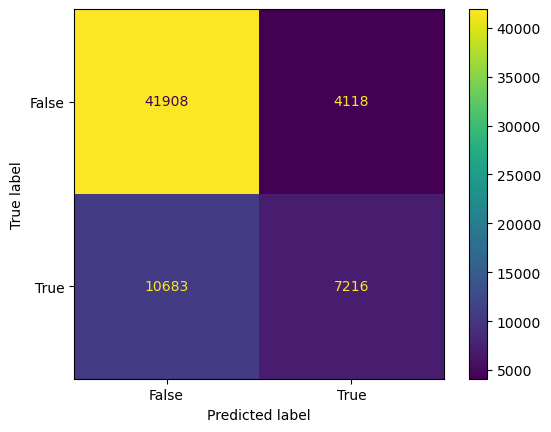

In [158]:
from sklearn import metrics

actual = np.asarray(test_labels)

# normalize test_data using previously defined mean and std
m = torch.mean(data, dim = 0)
s = torch.std(data, dim = 0)
test_data = (test_data - m)/s

predicted = []
# predicted is the sigmoid of the output from the net
for i, vector in enumerate(test_data): 
    prediction = torch.sigmoid(net(vector))
    predicted.append(prediction)
    
print(predicted[:100])
predicted = [1.0 if (x >.5) else 0.0 for x in predicted ]
predicted = np.asarray(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### Test

In [20]:
# input_path = "prepped_data_1.csv"
# test_data = np.genfromtxt(input_path,delimiter = ",", skip_header = 1, filling_values=0.0)
# test_tensor = torch.tensor(test_data).float()

# # test_sunrise_labels = weather_tensor[-TEST:, -2]
# # # test_sunset_labels = weather_tensor[-TEST:, -1]
# # test_data = weather_tensor[-TEST:,:-2] 



# for i, vector in enumerate(test_data): 
#     prediction = net(vector)
#     real = test_sunrise_labels[i]
#     print(prediction)

    
    

tensor([0.2959], grad_fn=<AddBackward0>)
tensor([0.2973], grad_fn=<AddBackward0>)
tensor([0.2867], grad_fn=<AddBackward0>)
tensor([0.2889], grad_fn=<AddBackward0>)
tensor([0.3009], grad_fn=<AddBackward0>)
tensor([0.3005], grad_fn=<AddBackward0>)
tensor([0.2902], grad_fn=<AddBackward0>)
tensor([0.3002], grad_fn=<AddBackward0>)
tensor([0.3016], grad_fn=<AddBackward0>)
tensor([0.3066], grad_fn=<AddBackward0>)
tensor([0.2860], grad_fn=<AddBackward0>)
tensor([0.2957], grad_fn=<AddBackward0>)
tensor([0.2839], grad_fn=<AddBackward0>)
tensor([0.2829], grad_fn=<AddBackward0>)
tensor([0.2827], grad_fn=<AddBackward0>)
tensor([0.2879], grad_fn=<AddBackward0>)
tensor([0.2905], grad_fn=<AddBackward0>)
tensor([0.2885], grad_fn=<AddBackward0>)
tensor([0.2826], grad_fn=<AddBackward0>)
tensor([0.2889], grad_fn=<AddBackward0>)
tensor([0.2897], grad_fn=<AddBackward0>)
tensor([0.2861], grad_fn=<AddBackward0>)
tensor([0.2883], grad_fn=<AddBackward0>)
tensor([0.2891], grad_fn=<AddBackward0>)
tensor([0.2905],

In [124]:
#pip3 install coremltools==5.0b5 protobuf==3.20.1



In [93]:
## This code will print out the real, then expected for every batch of 32 
# for batch in loader:
#     batchX = batch[0]
#     batchY = batch[1]
#     print(batchY)
#     print(net(batchX))
    

### Quantize and convert to TorchScript
The process of tracing takes an example input and traces its flow through the model. You can trace the model by creating an example image input, as shown in the above code using random data. To understand the reasons for tracing and how to trace a PyTorch model, see Model Tracing.


If your model uses a data-dependent control flow, such as a loop or conditional, the traced model won't generalize to other inputs. In such cases you can experiment with applying PyTorch's JIT script (torch.jit.script) to your model as described in Model Scripting. You can also use a combination of tracing and scripting.



In [136]:
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    net, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
)
# set model to evaluation mode
model_dynamic_quantized.eval()
example_tensor = weather_tensor[0,:-2]
# convert to torch script
traced_script_module = torch.jit.trace(net, example_tensor)


In [64]:
out = traced_script_module(example_tensor)
out

tensor([0.2868], grad_fn=<AddBackward0>)

### Convert to CoreML

In [65]:
import coremltools as ct

# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_script_module,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example_tensor.shape)]
 )

Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Converting PyTorch Frontend ==> MIL Ops:  92%|▉| 12/13 [00:00<00:00, 2968.72 ops/
Running MIL Common passes:   0%|                     | 0/40 [00:00<?, ? passes/s]/Users/lena/opt/anaconda3/envs/sunproject/lib/python3.9/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:107: UserWarning: Input, 'input.1', of the source model, has been renamed to 'input_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/Users/lena/opt/anaconda3/envs/sunproject/lib/python3.9/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:135: UserWarning: Output, '26', of the source model, has been renamed to 'var_26' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL Clean up passes: 100%|████████| 11/11 [00:00<00:00, 1150.24 passes/s]


got this message: 

Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion


ALSO: 
As an alternative, you can convert the model to a neural network by eliminating the convert_to parameter:

In [138]:
# Save the converted model.
model.save("sunrise_model1.mlpackage")

### success! (maybe?)
next step is to try integrating it into my app:
https://developer.apple.com/documentation/coreml/integrating_a_core_ml_model_into_your_app

### Optimize for pytorch model

In [ ]:
# from torch.utils.mobile_optimizer import optimize_for_mobile
# # optimize for mobile so that we can export and use in Swift app
# torchscript_model_optimized = optimize_for_mobile(traced_script_module)

# # save as .pt 
# path = os.path.join(os.getcwd(),"model.pt")
# torchscript_model_optimized._save_for_lite_interpreter(path)


### Test

In [128]:
row = 36
test = weather_tensor[row,:]
label = labels[row]
label

tensor([1.])

In [130]:
net(test)


tensor([0.8277], grad_fn=<AddBackward0>)

NOTES FROM CORY: HOW TO SPLIT UP training, validation, testing

def train(loader):
    one tound of training with all data in the loader
    
    
def eval(loader):
    feed evyerhting in batches to model, adds up and takes the losses of the batches
    



In [85]:
# # create a batch norm layer
# bn = torch.nn.BatchNorm1d(num_features = xdims)
# # normalize 
# data = bn(data) # how to extract the std and mean 
